## Задача мэтчинга (соответствия)

**Цель проекта:**

Необходимо разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base.csv и оценить качество алгоритма по метрике accuracy@5. Разработать REST API сервис, который по предложенным данным будем предлагать несколько похожих товаров


**Исходные данные:**

base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).

validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv

validation_answer.csv - правильные ответы к предыдущему файлу.








## Загрузим необходиые библитотеки и функции

In [1]:
#!pip install faiss-cpu

In [2]:
import pandas as pd
import numpy as np
import faiss

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

import joblib

In [3]:
pd.set_option('display.float_format', lambda x: '%.9f' % x)

## Загрузим данные из файлов, а также посмотрим общую информацию о датасетах, предварительно написав функцию get_info(), которая на вход принимает датасет, на выходе выдает следующую информацию - общую информацию, первые пять строк датасета, проверяет на наличие явных дубликатов и пропусков.

In [4]:
def get_info(data):
    display('Вывод первых 5-ти строк датасета', data.head())
    display(data.info())
    print('Количество явных дубликатов:', data.duplicated().sum())
    print('Количество пропусков:', data.duplicated().sum())
  

### Загрузим и исследуем данные из файла base.csv

In [5]:
base = pd.read_csv("base.csv", index_col=0)


In [6]:
get_info(base)

'Вывод первых 5-ти строк датасета'

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890000,11.152912000,-64.426760000,-118.880890000,216.482440000,-104.698060000,-469.070588343,44.348083000,120.915344000,181.449700000,...,-42.808693000,38.800827000,-151.762180000,-74.389089935,63.666340000,-4.703861000,92.933610000,115.269190000,-112.756639977,-60.830353000
1-base,-34.562202000,13.332763000,-69.787610000,-166.533480000,57.680607000,-86.098370000,-85.076665719,-35.637436000,119.718636000,195.234190000,...,-117.767525000,41.100000000,-157.829400000,-94.446806382,68.202110000,24.346846000,179.937930000,116.834000000,-84.888940631,-59.524610000
2-base,-54.233746000,6.379371000,-29.210136000,-133.413830000,150.895830000,-99.435326000,52.554795262,62.381706000,128.951450000,164.381470000,...,-76.397800000,46.011803000,-207.144420000,127.325569672,65.566180000,66.325680000,81.073490000,116.594154000,-1074.464887894,-32.527206000
3-base,-87.520130000,4.037883800,-87.803030000,-185.067630000,76.369540000,-58.985165000,-383.182844591,-33.611237000,122.031910000,136.233580000,...,-70.647940000,-6.358921000,-147.201050000,-37.692749819,66.202890000,-20.566910000,137.206940000,117.474100000,-1074.464887894,-72.915490000
4-base,-72.743850000,6.522048500,43.671265000,-140.608030000,5.820022600,-112.074080000,-397.711281629,45.182500000,122.167180000,112.119064000,...,-57.199104000,56.642403000,-159.351840000,85.944723718,66.766320000,-2.505783000,65.315285000,135.051590000,-1074.464887894,0.319400800


<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


None

Количество явных дубликатов: 0
Количество пропусков: 0


In [7]:
base.describe()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,2918139.000000000,2918139.000000000,2918139.000000000,2918139.000000000,2918139.000000000,2918139.000000000,2918139.000000000,2918139.000000000,2918139.000000000,2918139.000000000,...,2918139.000000000,2918139.000000000,2918139.000000000,2918139.000000000,2918139.000000000,2918139.000000000,2918139.000000000,2918139.000000000,2918139.000000000,2918139.000000000
mean,-86.229473558,8.080077089,-44.580804385,-146.634990829,111.316628433,-71.991376043,-392.223854012,20.352829293,123.684233781,124.458052745,...,-79.022859803,33.297347660,-154.796182618,14.151324417,67.791669655,23.544896386,74.959301483,115.566716025,-799.339025577,-47.791250969
std,24.891319717,4.953386769,38.631659635,19.844804624,46.348089747,28.186068161,271.654995149,64.216381908,6.356109389,64.430575851,...,30.456420989,28.886032592,41.229289674,98.951148314,1.823355695,55.342236448,61.345004756,21.175183394,385.413088002,41.748020553
min,-199.468700000,-13.914608000,-240.073400000,-232.667140000,-105.582960000,-211.008600000,-791.469870355,-301.859740000,93.153046000,-173.871950000,...,-220.566250000,-88.507740000,-353.902800000,-157.594384452,59.509445000,-233.138170000,-203.601620000,15.724480000,-1297.931468500,-226.780060000
25%,-103.065437500,4.708491300,-69.559490000,-159.905060000,80.507945000,-91.379940000,-629.331822548,-22.221473500,119.483983000,81.767510000,...,-98.763895000,16.988624000,-180.779850000,-71.300380398,66.580960000,-12.516241000,33.775736500,101.686670000,-1074.464887894,-75.666410000
50%,-86.231500000,8.038950000,-43.816605000,-146.776810000,111.873000000,-71.922300000,-422.201615751,20.804773000,123.892250000,123.497696000,...,-78.488120000,34.715020000,-153.977260000,13.826928576,67.814580000,23.416494000,74.929970000,116.024445000,-1074.464887894,-48.591960000
75%,-69.256577000,11.470065500,-19.625266000,-133.327655000,142.374275000,-52.441105000,-156.668582723,63.918212500,127.970480000,167.220605000,...,-58.533553000,52.164289500,-127.340477500,99.667530057,69.026665000,59.755113000,115.876040000,129.552375000,-505.744455875,-19.714245000
max,21.515549000,29.937210000,160.937230000,-51.374780000,319.664500000,58.806244000,109.632533112,341.228200000,152.261200000,427.542050000,...,60.174110000,154.167760000,24.360992000,185.098068928,75.712030000,314.898770000,339.573850000,214.706340000,98.770811353,126.973220000


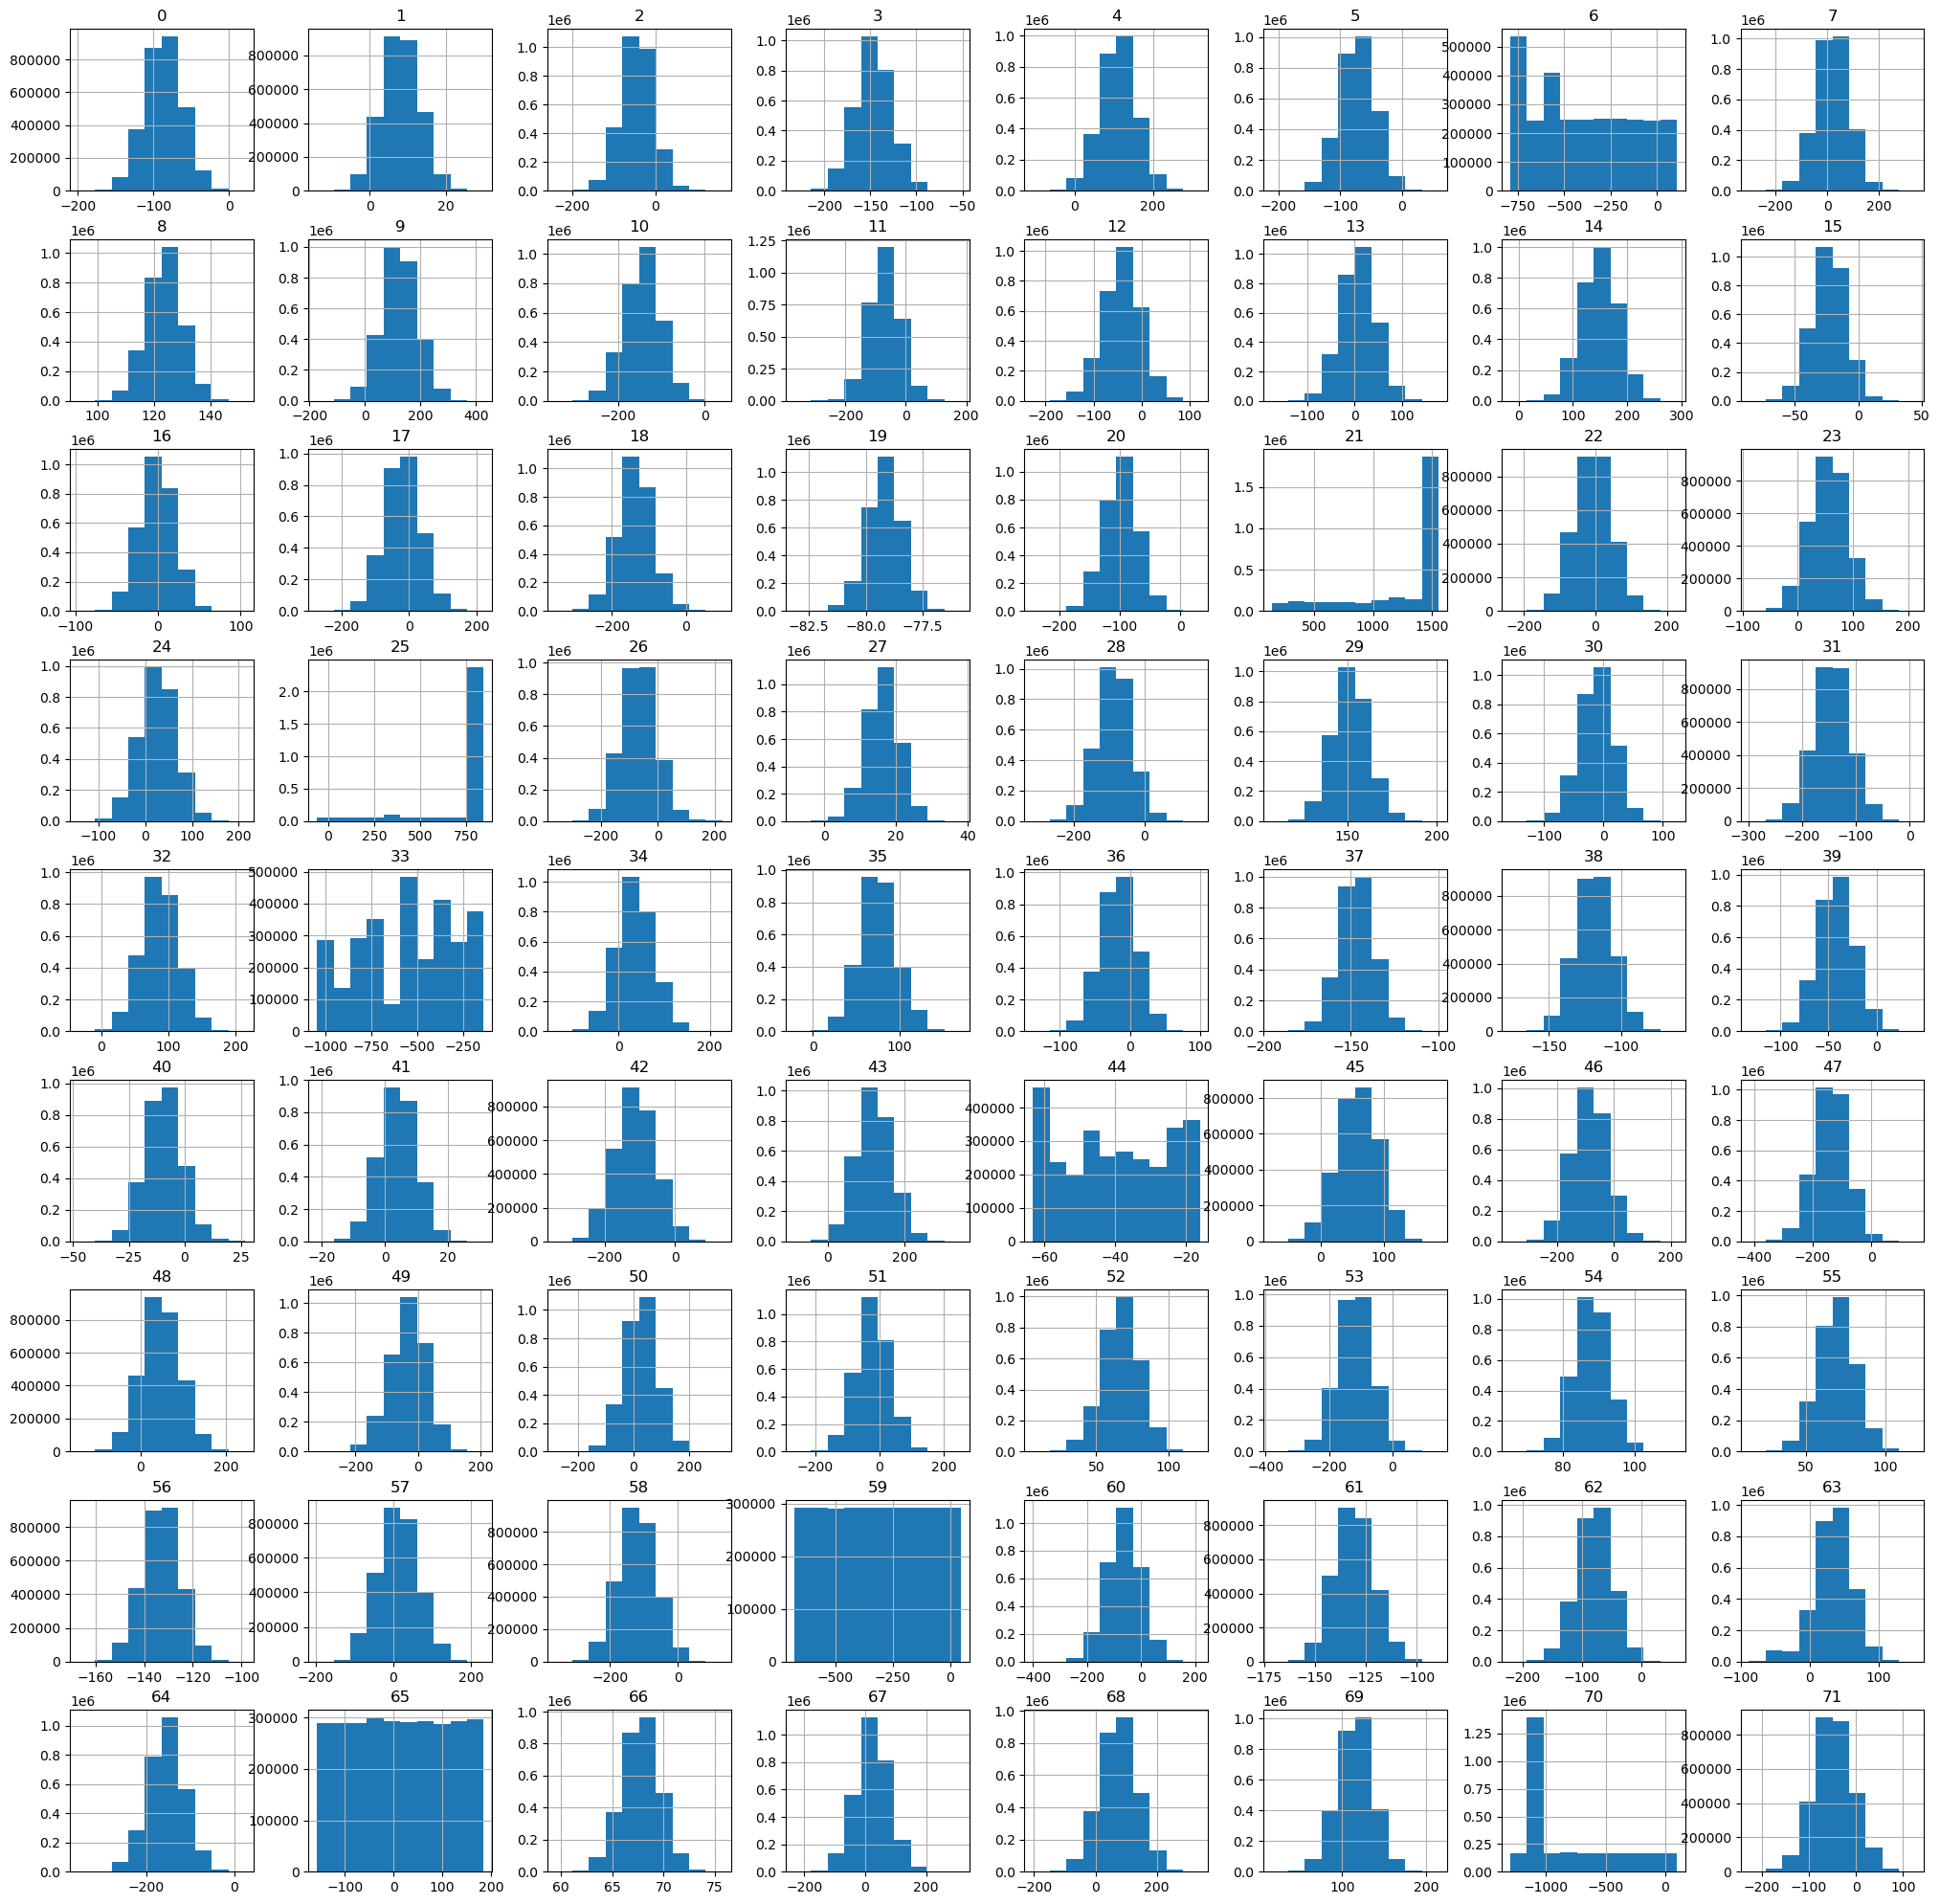

In [8]:
base.hist(figsize=(25,25));

**Вывод** Из полученных данных видим, что в датасете 72 колонки и 2918139 строк. Дубликатов и пропусков нет. Все значения числовые (формат float64), названий у признаков нет, поэтому сложно понять о чем идет речь, скорее всего данные закодированы. Диапазон значений у признаков разный. Распределение большинства признаков близко к нормальному, за исключением признаков с номерами: 6, 21, 25, 33, 44, 59, 65, 70. 

### Загрузим и исследуем данные из файла train.csv

In [9]:
train = pd.read_csv("train.csv", index_col=0)


In [10]:
get_info(train)

'Вывод первых 5-ти строк датасета'

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748000,17.971436000,-42.117104000,-183.936680000,187.517490000,-87.144930000,-347.360606102,38.307602000,109.085560000,30.413513000,...,70.107360000,-155.802570000,-101.965942959,65.903790000,34.457500000,62.642094000,134.763600000,-415.750253933,-25.958572000,675816-base
1-query,-87.776370000,6.806267700,-32.054546000,-177.260390000,120.803330000,-83.810590000,-94.572748687,-78.433090000,124.915900000,140.331070000,...,4.669178000,-151.697710000,-1.638703918,68.170876000,25.096191000,89.974976000,130.589630000,-1035.092210911,-51.276833000,366656-base
2-query,-49.979565000,3.841486200,-116.118590000,-180.401980000,190.128430000,-50.837620000,26.943937452,-30.447489000,125.771164000,211.607820000,...,78.039764000,-169.146200000,82.144186047,66.008220000,18.400496000,212.409730000,121.931470000,-1074.464887894,-22.547178000,1447819-base
3-query,-47.810562000,9.086598000,-115.401695000,-121.011360000,94.652840000,-109.255410000,-775.150134290,79.186520000,124.003100000,242.650650000,...,44.515266000,-145.416750000,93.990980701,64.131350000,106.061920000,83.178760000,118.277725000,-1074.464887894,-19.902788000,1472602-base
4-query,-79.632126000,14.442886000,-58.903397000,-147.052540000,57.127068000,-16.239529000,-321.317963811,45.984676000,125.941284000,103.392670000,...,45.028910000,-196.092070000,-117.626336636,66.926220000,42.456170000,77.621765000,92.479930000,-1074.464887894,-21.149351000,717819-base


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21  

None

Количество явных дубликатов: 0
Количество пропусков: 0


In [11]:
train.describe()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,100000.000000000,100000.000000000,100000.000000000,100000.000000000,100000.000000000,100000.000000000,100000.000000000,100000.000000000,100000.000000000,100000.000000000,...,100000.000000000,100000.000000000,100000.000000000,100000.000000000,100000.000000000,100000.000000000,100000.000000000,100000.000000000,100000.000000000,100000.000000000
mean,-85.328678588,7.664345283,-43.667045570,-146.118630484,111.770591502,-73.178791952,-440.615118037,21.231588267,123.067890926,126.120200579,...,-81.145553278,36.898233391,-152.223081506,14.001695234,67.799560462,23.029277333,73.412075719,115.189716769,-709.761548126,-48.505703629
std,25.803845287,4.955650663,39.111064069,20.434840537,47.700957546,28.718853141,279.017549991,65.985214369,6.492080873,64.912752417,...,30.675870788,25.357685926,41.020285043,99.079597168,1.838011568,55.470761134,62.203131534,21.582237824,405.961084452,41.215123600
min,-186.280270000,-11.560507000,-224.896060000,-223.307220000,-93.272020000,-184.962450000,-791.469481798,-278.582820000,94.831150000,-142.156950000,...,-210.059310000,-60.779335000,-317.831670000,-157.590189049,60.668890000,-203.746380000,-181.973820000,22.598862000,-1297.871984104,-209.935760000
25%,-103.309147500,4.313784100,-69.494487500,-160.028520000,79.474322500,-92.834079500,-738.536868423,-22.131763500,118.674642500,82.545027500,...,-101.504830000,19.774803500,-178.929470000,-71.745017755,66.560655000,-14.144571500,31.685547500,100.589323750,-1074.464887894,-76.478591250
50%,-85.273695000,7.652854350,-42.830246000,-146.067445000,112.260100000,-73.364420000,-511.837757752,22.278988500,123.087540000,125.963340000,...,-80.859640000,36.711365000,-151.576985000,14.072662528,67.813585000,23.441362500,72.880192500,115.236635000,-808.801695753,-48.700929000
75%,-67.330810000,10.981190750,-17.713689500,-132.277745000,143.760830000,-53.699612250,-201.116577579,65.899595000,127.541802500,169.701005000,...,-60.492450500,53.919520000,-124.436974000,100.011024358,69.058750000,59.941064750,114.469223750,129.791085000,-357.087323145,-20.487869250
max,14.585236000,28.917845000,128.108460000,-60.751625000,301.363600000,51.849710000,109.625188491,288.171840000,149.356200000,392.827150000,...,47.733450000,145.667130000,11.907364000,185.095136510,74.779884000,266.493320000,319.867520000,201.761260000,98.768232554,126.191790000


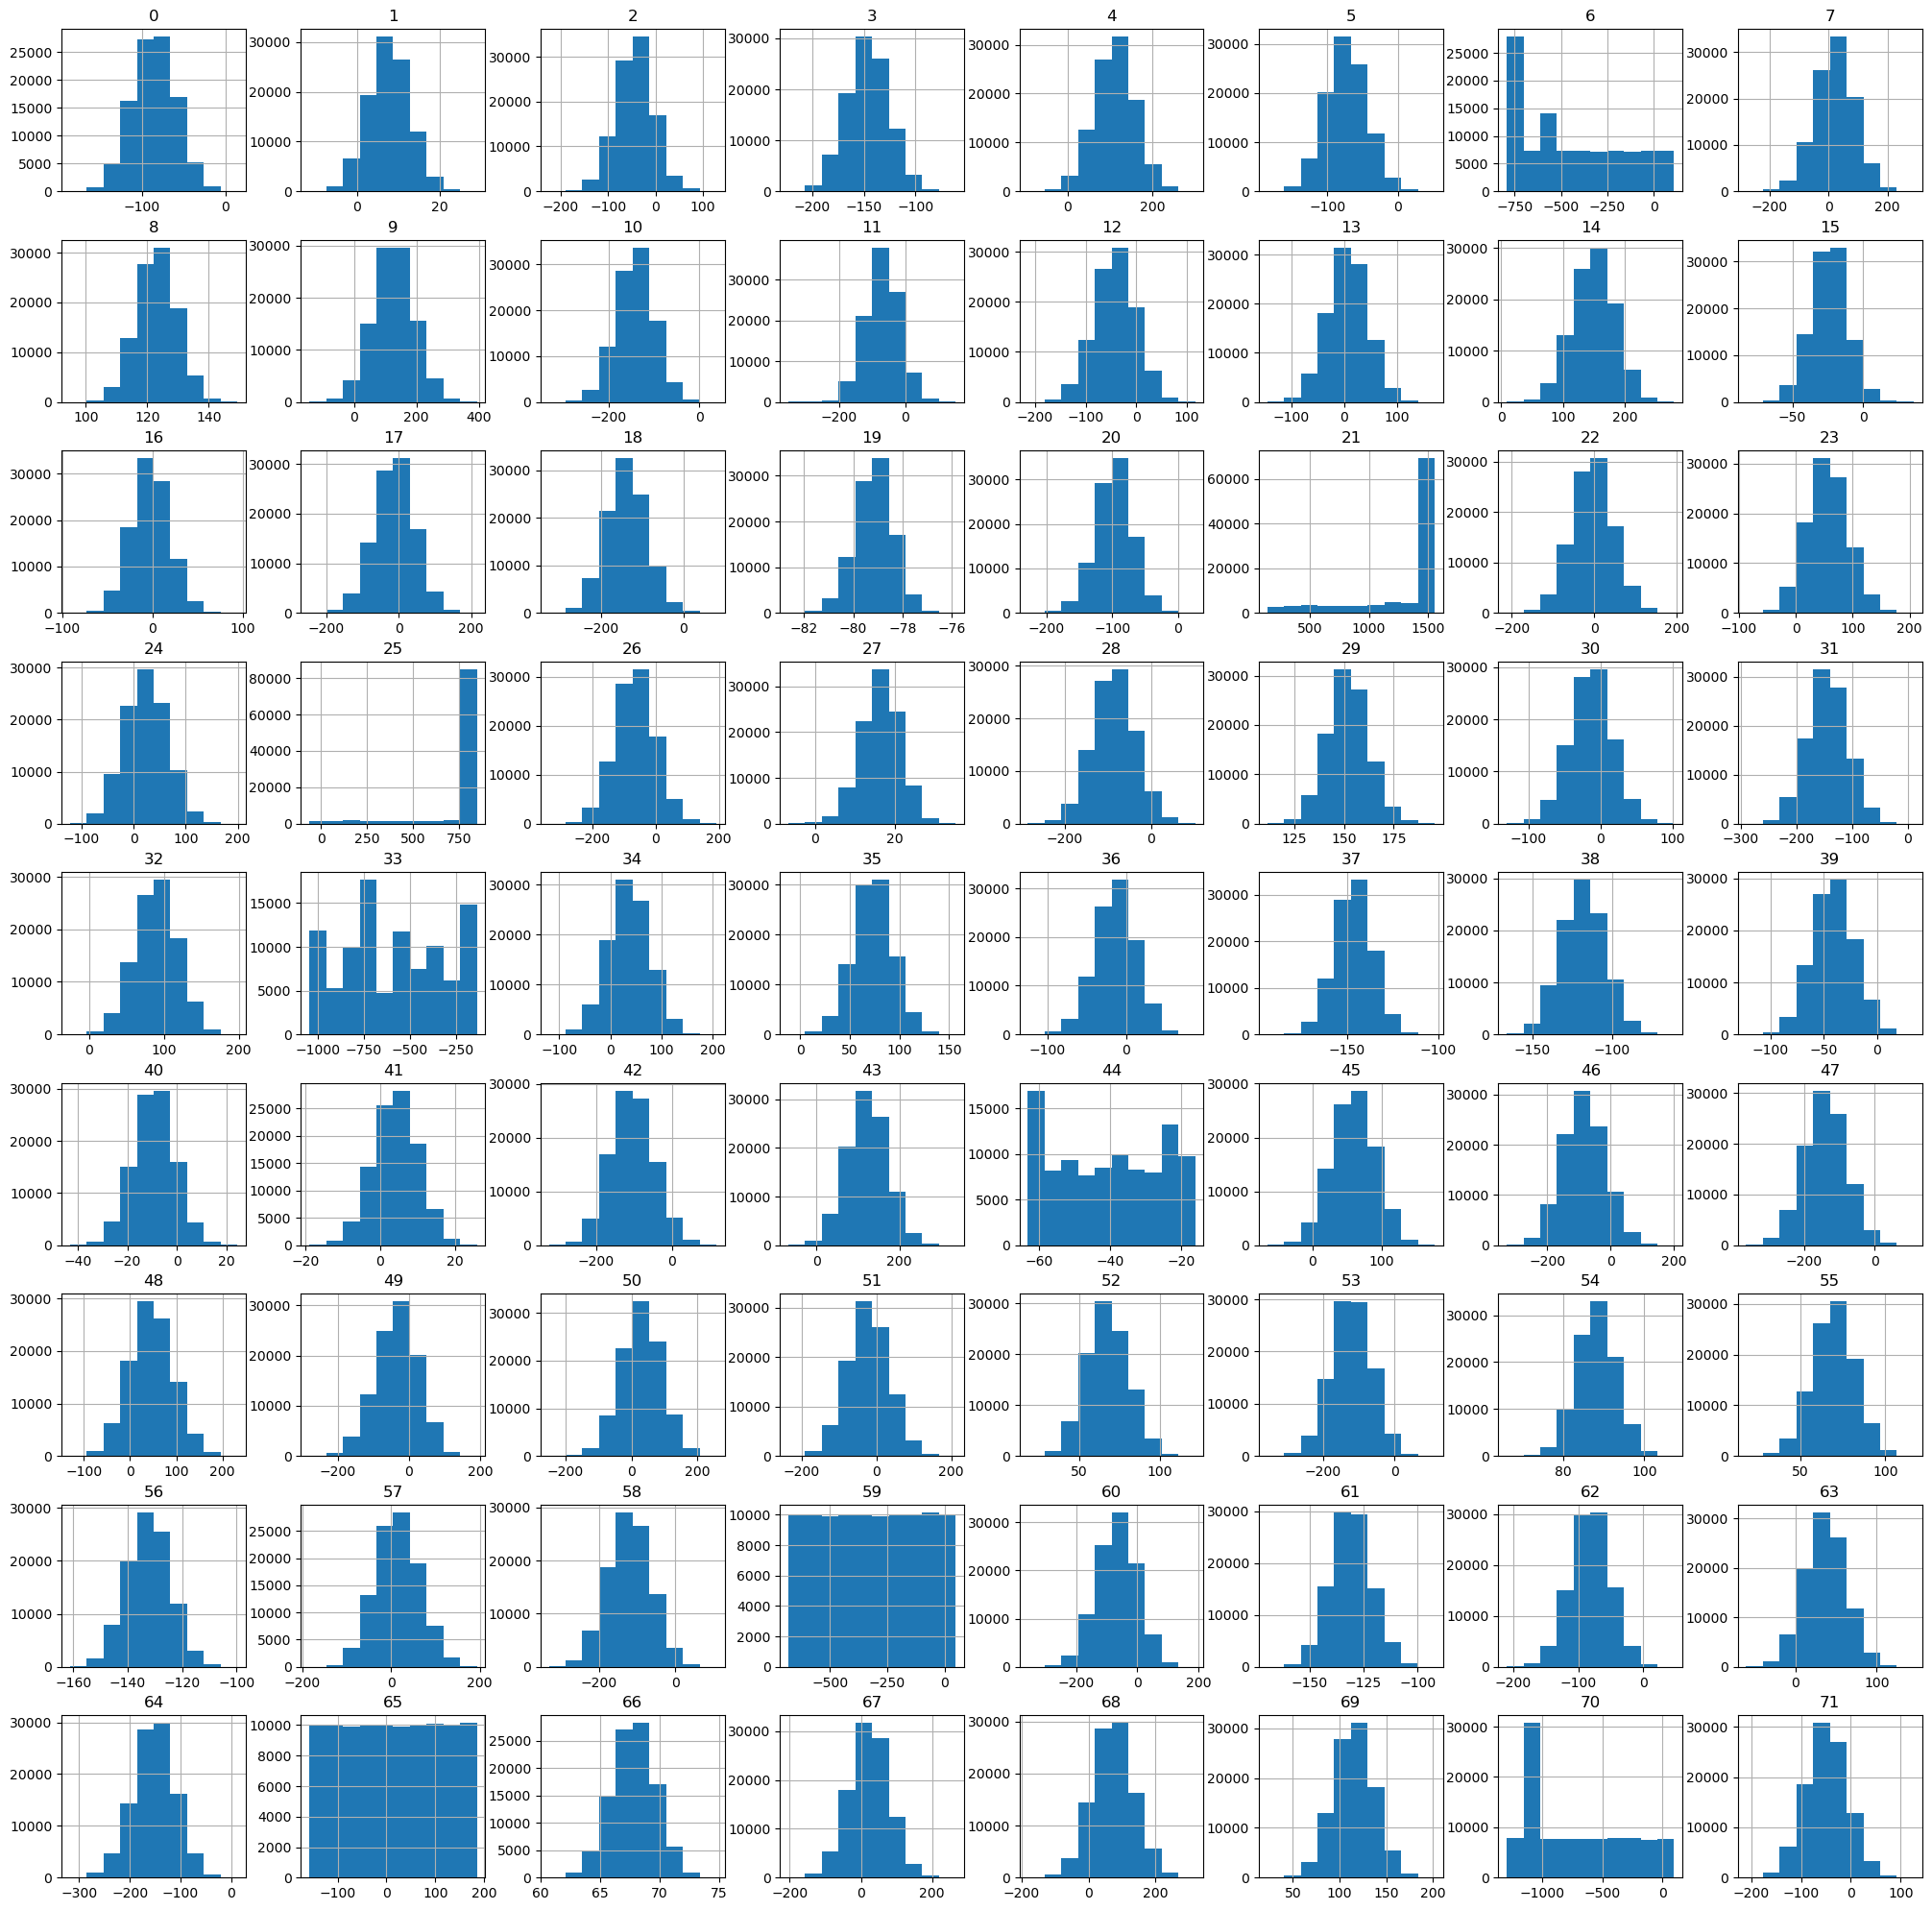

In [12]:
train.hist(figsize=(25,25));

**Вывод** Из полученных данных видим, что в датасете 73 колонки и 100000 строк. 73 столбец (Target) - это целевое значение, номер строки в датасете base. Дубликатов и пропусков нет. Все значения числовые (формат float64), названий у признаков нет, поэтому сложно понять о чем идет речь, скорее всего данные закодированы. Диапазон значений у признаков разный и немного отличается от диапазона значений аналогичных признаков в датасете base. Распределение большинства признаков близко к нормальному, за исключением признаков с номерами: 6, 21, 25, 33, 44, 59, 65, 70, также как и в датасете base.

### Загрузим и исследуем данные из файла validation.csv

In [13]:
validation = pd.read_csv("validation.csv", index_col=0)


In [14]:
get_info(validation)

'Вывод первых 5-ти строк датасета'

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734000,3.597751600,-13.213642000,-125.926790000,110.745940000,-81.279594000,-461.003171855,139.815720000,112.880980000,75.215750000,...,-75.513020000,52.830902000,-143.439450000,59.051935097,69.282240000,61.927513000,111.592530000,115.140656000,-1099.130484880,-117.079360000
100001-query,-53.758705000,12.790300000,-43.268543000,-134.417620000,114.449910000,-90.520130000,-759.626064847,63.995087000,127.117905000,53.128998000,...,-79.441830000,29.185436000,-168.605900000,-82.872442868,70.765600000,-65.975950000,97.077160000,123.391640000,-744.442331602,-25.009320000
100002-query,-64.175095000,-3.980927000,-7.679249000,-170.160930000,96.446160000,-62.377740000,-759.626064847,87.477554000,131.270110000,168.920320000,...,-134.795410000,37.368730000,-159.662310000,-119.232724569,67.710440000,86.002060000,137.636410000,141.081630000,-294.052271346,-70.969604000
100003-query,-99.286860000,16.123936000,9.837166000,-148.060440000,83.697080000,-133.729720000,58.576403475,-19.046660000,115.042404000,75.206730000,...,-77.236110000,44.100494000,-132.530120000,-106.318981779,70.883960000,23.577892000,133.183960000,143.252940000,-799.363666988,-89.392670000
100004-query,-79.532920000,-0.364172940,-16.027431000,-170.884950000,165.453920000,-28.291668000,33.931936169,34.411217000,128.903980000,102.086914000,...,-123.770250000,45.635944000,-134.258930000,13.735358841,70.617630000,15.332115000,154.568120000,101.700640000,-1171.892332435,-125.307890000


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21

None

Количество явных дубликатов: 0
Количество пропусков: 0


In [15]:
validation.describe()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,100000.000000000,100000.000000000,100000.000000000,100000.000000000,100000.000000000,100000.000000000,100000.000000000,100000.000000000,100000.000000000,100000.000000000,...,100000.000000000,100000.000000000,100000.000000000,100000.000000000,100000.000000000,100000.000000000,100000.000000000,100000.000000000,100000.000000000,100000.000000000
mean,-85.302232882,7.669724380,-43.842473719,-146.119796776,111.635071371,-73.273041826,-441.396759177,21.594242235,123.077725158,126.001061622,...,-81.129311365,36.778881660,-152.341248796,14.397762051,67.788892292,23.250779241,73.114445529,115.196935177,-709.457021268,-48.416276038
std,25.777320933,4.956990079,39.138775396,20.495540741,47.751575957,28.515739852,279.242585296,66.478047813,6.504930677,64.981696675,...,30.691590400,25.427102601,41.246347139,98.695230782,1.844522269,55.403861611,62.056223997,21.493080545,405.665763710,41.292843359
min,-190.353330000,-11.109877000,-217.538420000,-220.050890000,-81.198990000,-176.705030000,-791.460243483,-265.608430000,96.218350000,-135.667300000,...,-215.152280000,-66.265970000,-337.632870000,-157.593540520,60.377728000,-210.672800000,-175.921780000,25.271042000,-1297.923998764,-209.935760000
25%,-103.231790000,4.292425125,-69.680916250,-160.210287500,79.101920000,-92.789802500,-740.620024758,-21.804729750,118.657688750,82.311205000,...,-101.690472500,19.564135000,-179.115082500,-70.420034287,66.546130000,-13.863008250,31.494840500,100.538862500,-1074.464887894,-76.359190000
50%,-85.296745000,7.657887950,-43.230835000,-146.080365000,111.959330000,-73.579282500,-513.922978090,22.138012000,123.062568000,126.083595000,...,-81.027250000,36.414150500,-151.426035000,14.768217949,67.800445000,23.508739500,72.152398000,115.280990000,-807.029697216,-48.670001000
75%,-67.422103750,10.993899750,-17.765820750,-132.119277500,143.903735000,-53.861138750,-202.572440368,66.097697500,127.538967500,169.680500000,...,-60.274745000,53.888419750,-124.400437500,99.803923278,69.040832500,60.154775000,114.317052500,129.770215000,-358.400477883,-20.283335250
max,14.427986000,27.409784000,134.859800000,-57.381890000,302.065370000,50.255325000,109.632034617,279.468900000,151.822560000,392.827150000,...,41.390480000,141.025270000,14.602035500,185.094333431,75.400475000,251.288590000,305.937530000,201.599980000,98.737079171,111.831955000


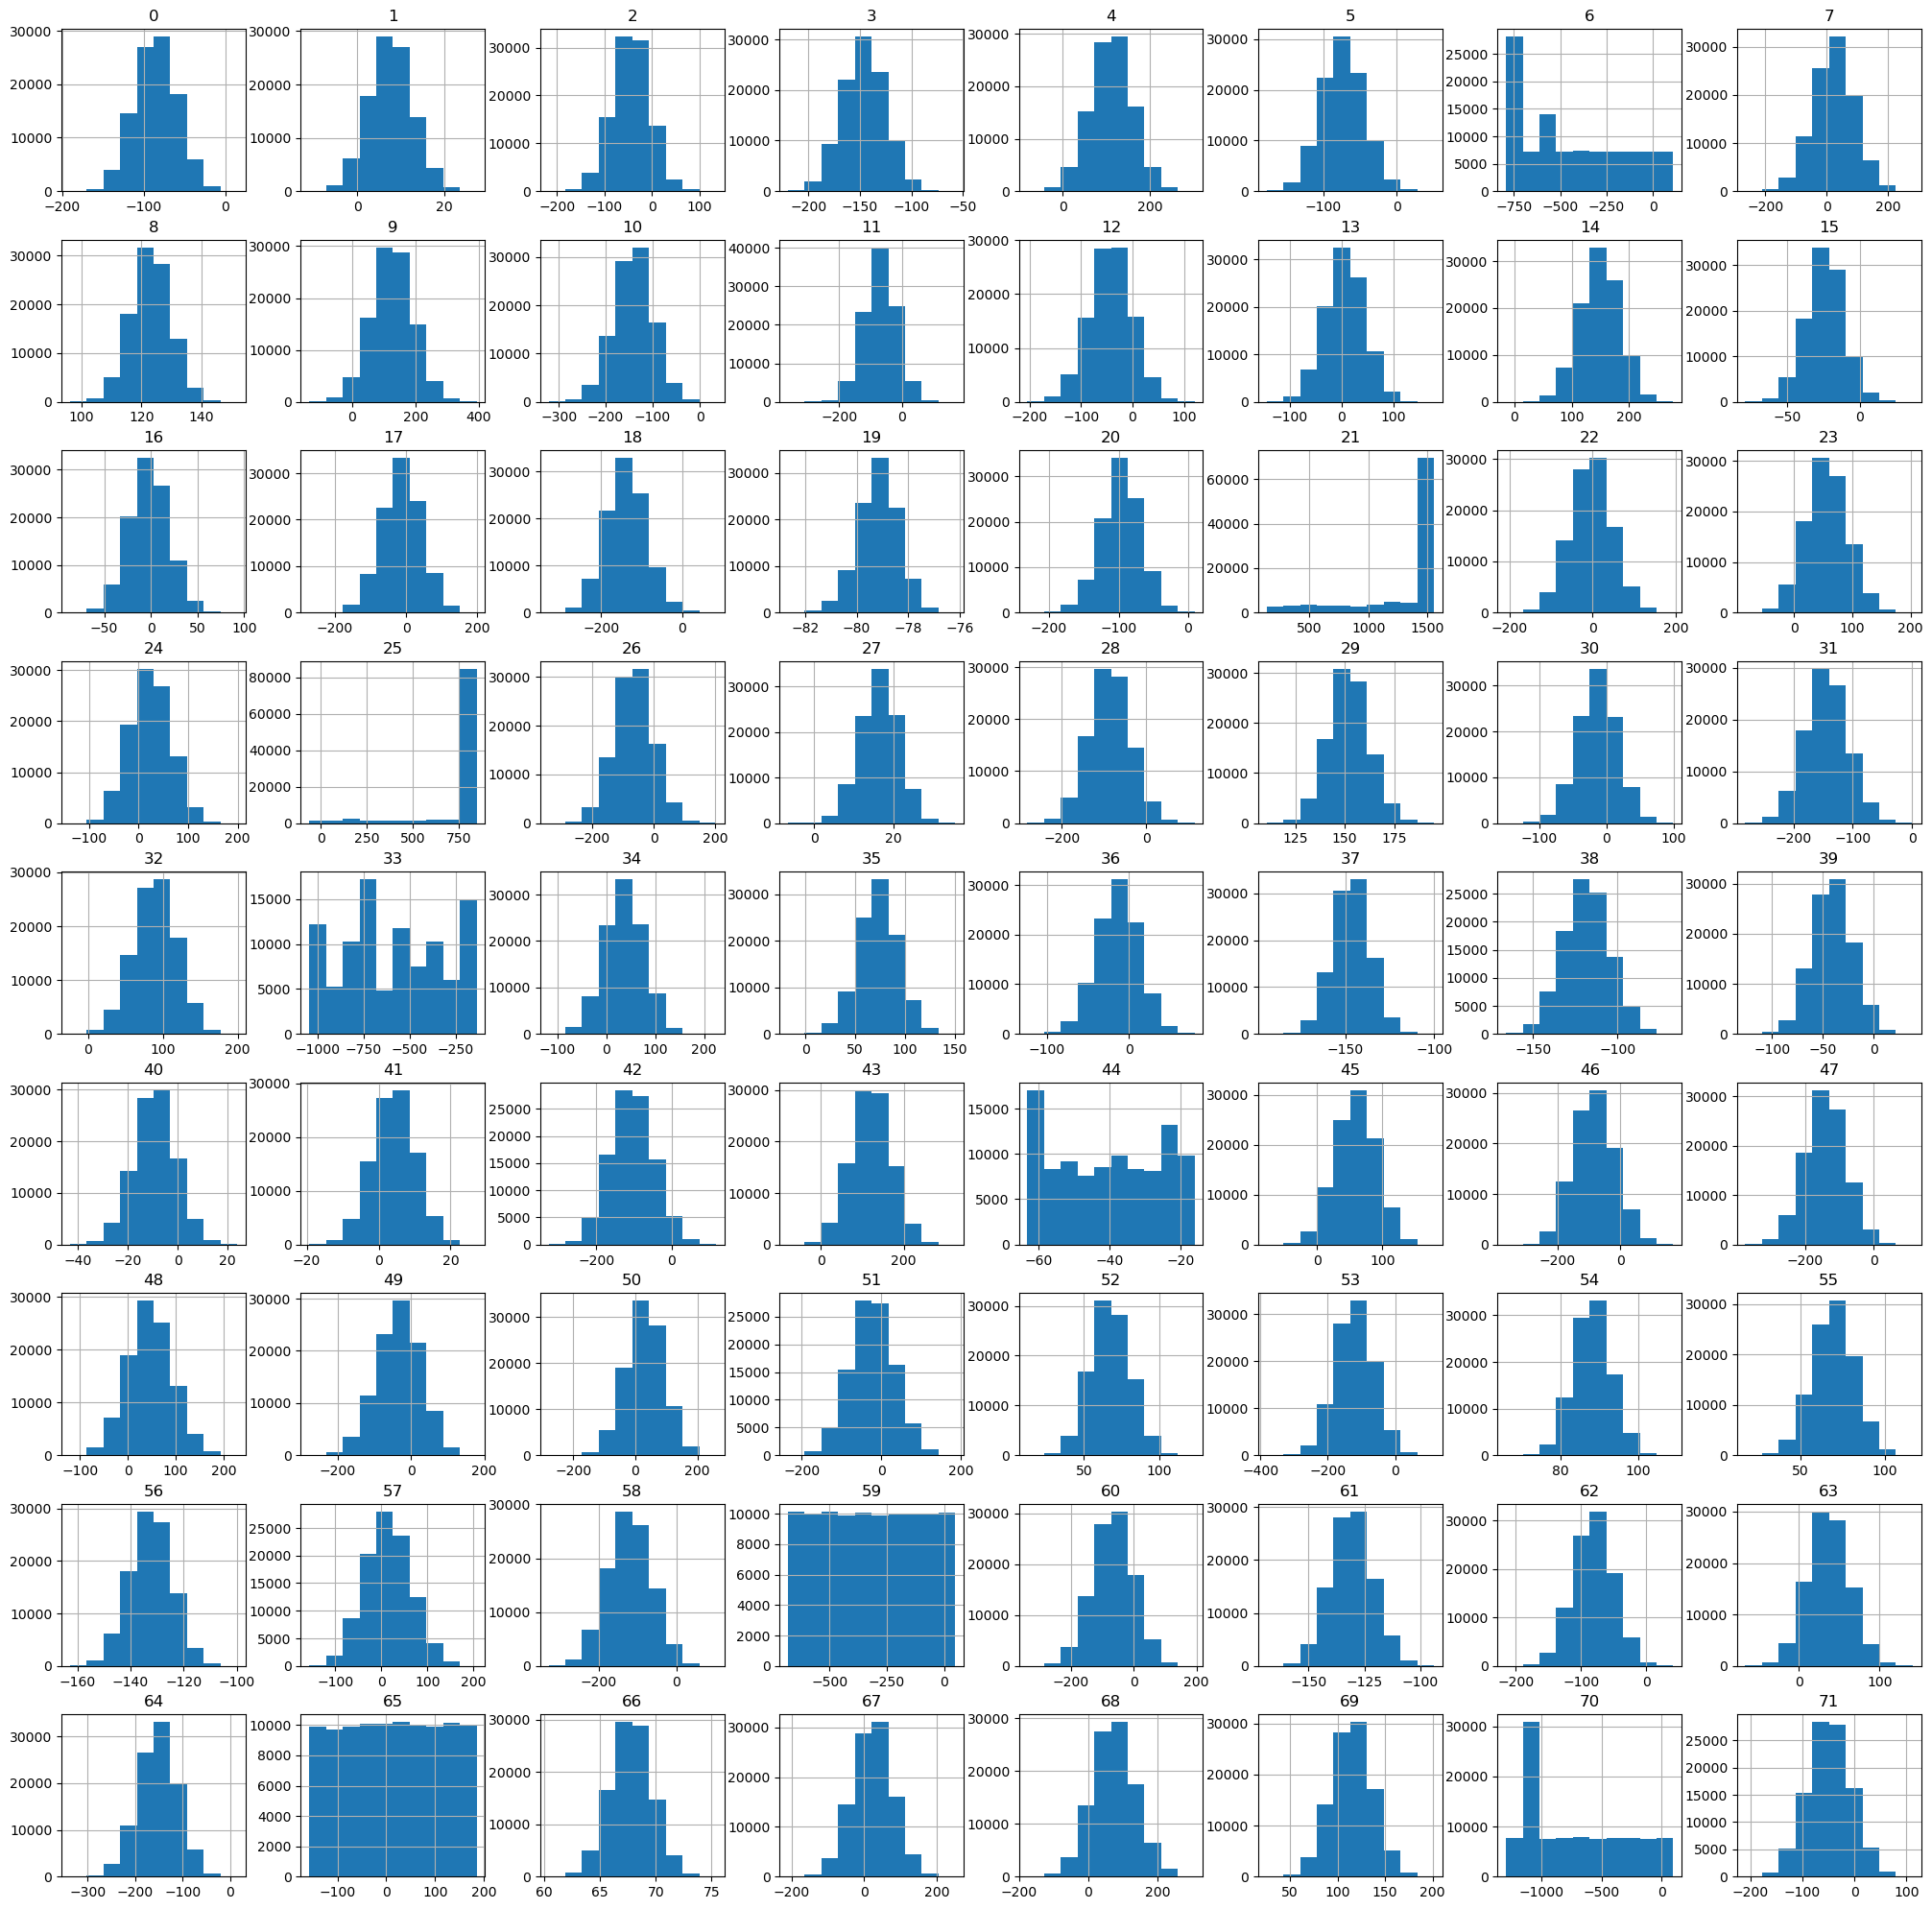

In [16]:
validation.hist(figsize=(25,25));

**Вывод** Из полученных данных видим, что в датасете 72 колонки и 100000 строк. Дубликатов и пропусков нет. В плане распределения значений признаков наблюдается аналогичная картина.

### Загрузим данные из файла validation_answer.csv

In [17]:
df_validation_answer = pd.read_csv("validation_answer.csv", index_col=0)
print(df_validation_answer.shape)
df_validation_answer.head()

(100000, 1)


,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


**Вывод** Из полученных данных видим, что в датасете  100000 строк, это целевой признак для нашей тестовой выборки.

## Подготовим данные

### Так как нам необходимо находить расстояние между векторами, то данные необходимо нормализовать (масштабировать). Для начала попробуем использовать MinMaxScaler

In [18]:
num_columns = base.select_dtypes(include='number').columns
print(num_columns)
scaler = MinMaxScaler()
scaler.fit(base[num_columns])
base[num_columns] = scaler.transform(base[num_columns])
display(base.head())
train[num_columns] = scaler.transform(train[num_columns])
train.head()

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71'],
      dtype='object')


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,0.381858935,0.571641522,0.438009935,0.627639521,0.757359962,0.394012940,0.357783178,0.538352224,0.469686433,0.590810407,...,0.633174215,0.524604119,0.534390614,0.242798736,0.256557518,0.416822831,0.545928979,0.500270276,0.848552226,0.469111430
1-base,0.746236434,0.621351001,0.424641586,0.364790110,0.383926025,0.462947954,0.783921119,0.413974960,0.449440360,0.613730542,...,0.366170098,0.534078389,0.518350961,0.184268949,0.536498651,0.469831497,0.706106169,0.508134360,0.868504724,0.472802542
2-base,0.657218579,0.462785351,0.525829612,0.547476518,0.603128329,0.413517923,0.936657879,0.566394459,0.605642396,0.562430239,...,0.513529476,0.554318598,0.387978927,0.831415899,0.373812882,0.546430045,0.524094194,0.506928993,0.159995859,0.549119584
3-base,0.506590721,0.409389909,0.379716543,0.262556624,0.427874396,0.563436143,0.453097255,0.417125694,0.488576652,0.515627388,...,0.534010536,0.338513031,0.546448680,0.349881164,0.413109698,0.387877613,0.627437318,0.511351236,0.159995859,0.434948815
4-base,0.573456482,0.466038979,0.707573924,0.507793654,0.261972129,0.366675601,0.436974296,0.539649741,0.490865169,0.475531022,...,0.581915425,0.598124421,0.514326150,0.710663762,0.447883779,0.420833652,0.495082933,0.599688384,0.159995859,0.641971322


,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,0.658806918,0.727131632,0.493643513,0.268794890,0.689246798,0.459069146,0.492851048,0.528959293,0.269548496,0.339675270,...,0.653609862,0.523709206,0.162327594,0.394649681,0.488280352,0.490161520,0.598241066,0.631617222,0.567687989,675816-base
1-query,0.505431181,0.472520334,0.518736508,0.305620987,0.532363650,0.471427028,0.773382824,0.347427834,0.537368398,0.522440482,...,0.383956839,0.534561050,0.455089334,0.534570934,0.471198823,0.540482058,0.577264430,0.188185601,0.496117596,366656-base
2-query,0.676469638,0.404911245,0.309106045,0.288292127,0.695386611,0.593632943,0.908236183,0.422045313,0.551837873,0.640955764,...,0.686297150,0.488433215,0.699573533,0.401094949,0.458981225,0.765887587,0.533752122,0.159995859,0.577331416,1447819-base
3-query,0.686284831,0.524521150,0.310893766,0.615887950,0.470868891,0.377122283,0.018110856,0.592525899,0.521925520,0.692572172,...,0.548151775,0.551165759,0.734143290,0.285257260,0.618936545,0.527970050,0.515389920,0.159995859,0.584806654,1472602-base
4-query,0.542285591,0.646666325,0.451783542,0.472246045,0.382624338,0.721861956,0.521751917,0.540897122,0.554715987,0.461021227,...,0.550268362,0.417197557,0.116629495,0.457752575,0.502875481,0.517739479,0.385740941,0.159995859,0.581282834,717819-base


In [19]:
validation[num_columns] = scaler.transform(validation[num_columns])
validation.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,0.643014001,0.399353103,0.565720061,0.588774673,0.508712974,0.480807520,0.366736008,0.686804141,0.333759941,0.414170106,...,0.516681071,0.582418258,0.556393063,0.632188767,0.603162705,0.538404734,0.580280531,0.499624318,0.142335977,0.310105111
100001-query,0.659368239,0.608980636,0.490772170,0.541939660,0.517423126,0.446559827,0.035338720,0.568903262,0.574622226,0.377445400,...,0.502686611,0.484981698,0.489861583,0.218043732,0.694713529,0.305019986,0.553557361,0.541090329,0.396282833,0.570371362
100002-query,0.612231893,0.226528373,0.579521174,0.344781269,0.475086012,0.550862428,0.035338720,0.605418435,0.644869809,0.569977204,...,0.305516599,0.518702836,0.513505374,0.111941945,0.506153493,0.582333428,0.628227983,0.629992855,0.718749594,0.440449502
100003-query,0.453343804,0.685001110,0.623201849,0.466686517,0.445105633,0.286414487,0.943340369,0.439773571,0.370327214,0.414155108,...,0.510543407,0.546442612,0.585233598,0.149625129,0.702018536,0.468428391,0.620030908,0.640904955,0.356960684,0.388370646
100004-query,0.542734519,0.309005092,0.558703317,0.340787610,0.637362725,0.677193772,0.915991127,0.522900425,0.604839292,0.458850083,...,0.344788330,0.552769785,0.580663216,0.499951900,0.685581035,0.453382367,0.659399696,0.432080392,0.090240517,0.286844464


### Попробуем использовать StandardScaler - закомментировала данную ячейку, т.к. показатели при использовании MinMaxScaler лучше.

In [20]:
# num_columns = df_base.select_dtypes(include='number').columns
# print(num_columns )
# scaler = StandardScaler()
# scaler.fit(df_base[num_columns])
# df_base[num_columns] = scaler.transform(df_base[num_columns])
# display(df_base.head())
# features_train[num_columns] = scaler.transform(features_train[num_columns])
# display(features_train.head())
# df_validation[num_columns] = scaler.transform(df_validation[num_columns])
# df_validation.head()

### Удалим из датасетов (base,train, validation) столбцы, в которых данные не имеют распределния схожего с нормальным. Разобьем датасет train на target_train (содержит целевой признак Target) и features_train (содержит оставшиеся признаки)

In [21]:
df_base = base.drop(['6', '21', '25', '33', '44', '59', '65', '70'], axis=1)
df_base.shape

(2918139, 64)

In [22]:
target_train = train['Target']
features_train = train.drop(['Target', '6', '21', '25', '33', '44', '59', '65', '70'], axis=1)
print(target_train.shape)
display(features_train.head())
features_train.shape

(100000,)


,0,1,2,3,4,5,7,8,9,10,...,60,61,62,63,64,66,67,68,69,71
Id,,,,,,,,,,,,,,,,,,,,,
0-query,0.658806918,0.727131632,0.493643513,0.268794890,0.689246798,0.459069146,0.528959293,0.269548496,0.339675270,0.663879430,...,0.523843387,0.474508681,0.410124251,0.653609862,0.523709206,0.394649681,0.488280352,0.490161520,0.598241066,0.567687989
1-query,0.505431181,0.472520334,0.518736508,0.305620987,0.532363650,0.471427028,0.347427834,0.537368398,0.522440482,0.431504028,...,0.683198093,0.413309517,0.640285625,0.383956839,0.534561050,0.534570934,0.471198823,0.540482058,0.577264430,0.496117596
2-query,0.676469638,0.404911245,0.309106045,0.288292127,0.695386611,0.593632943,0.422045313,0.551837873,0.640955764,0.668385908,...,0.530638288,0.391245648,0.600321906,0.686297150,0.488433215,0.401094949,0.458981225,0.765887587,0.533752122,0.577331416
3-query,0.686284831,0.524521150,0.310893766,0.615887950,0.470868891,0.377122283,0.592525899,0.521925520,0.692572172,0.512201137,...,0.400170294,0.488975251,0.566356768,0.548151775,0.551165759,0.285257260,0.618936545,0.527970050,0.515389920,0.584806654
4-query,0.542285591,0.646666325,0.451783542,0.472246045,0.382624338,0.721861956,0.540897122,0.554715987,0.461021227,0.614378518,...,0.441781655,0.828226106,0.540697640,0.550268362,0.417197557,0.457752575,0.502875481,0.517739479,0.385740941,0.581282834


(100000, 64)

In [23]:
df_validation = validation.drop(['6', '21', '25', '33', '44', '59', '65', '70'], axis=1)
df_validation.shape

(100000, 64)

In [24]:
target_train

Id
0-query         675816-base
1-query         366656-base
2-query        1447819-base
3-query        1472602-base
4-query         717819-base
                   ...     
99995-query     811868-base
99996-query    1460772-base
99997-query    2366140-base
99998-query       9252-base
99999-query    2769109-base
Name: Target, Length: 100000, dtype: object

## Создадим индексы

In [25]:
dims = df_base.shape[1] # размерность каждого вектора
print(dims)
n_cells = 1000  # количество кластеров, которое должно быть сформировано
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

64


In [26]:
idx_l2.train(np.ascontiguousarray(df_base.values[:50000, :]).astype('float32')) # обучаем индекс
print(idx_l2.is_trained)   # определяет обучен индекс или нет
print(idx_l2.ntotal)   # показывает общее количество векторов добавленных к индексу, тут у нас пустой индекс
idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))
print(idx_l2.ntotal)

True
0
2918139


In [27]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

## Выполним поиск пяти ближайщих соседей для данных в df_train. Для этого разделем датасет на признаки и целкевой признак.

In [28]:
%%time
k = 5
idx_l2.nprobe = 20
distances, idx = idx_l2.search(np.ascontiguousarray(features_train.values).astype('float32'), k)

Wall time: 38.1 s


In [29]:
distances[0:5]

array([[1.1522013e-01, 1.2419149e-01, 1.2953143e-01, 1.3906729e-01,
        1.3920519e-01],
       [1.3050914e-01, 1.5877250e-01, 2.1046731e-01, 2.7118012e-01,
        2.7118012e-01],
       [1.7406943e-01, 1.7680453e-01, 1.9686788e-01, 2.0385286e-01,
        2.2076166e-01],
       [1.2270492e-01, 3.0924821e-01, 3.7487260e-01, 3.9160699e-01,
        4.0651679e-01],
       [1.7787574e-08, 5.9508258e-03, 1.3696792e-02, 1.5106129e-02,
        1.7851098e-02]], dtype=float32)

In [30]:
idx[0:5]

array([[ 336969, 1113711, 1818641,  232405,  480296],
       [  15185,  519311,  737853,  223456, 2524968],
       [1162532,  173120, 1784963,  137853, 2863071],
       [1179186,  980736,  556881, 1280070,  446031],
       [ 631912,  726816, 2910931, 1304565,  557487]], dtype=int64)

In [31]:
acc_5 = 0
for target, el in zip(target_train.values.tolist(), idx.tolist()):
    acc_5 += int(target in [base_index[r] for r in el])

print(100 * acc_5 / len(idx))

70.202


**Вывод:**
Во время эксперементов проверяла значение метрики acc_5 на разных значениях параметров n_cells (количества кластеров) и nprobe (количество ближайщих кластеров, по которым необходимо пройтись)  и с использовала MinMaxScaler и StandardScaler. Лучшие результаты получились при использовании MinMaxScaler, хотя разница и незначительна (accuracy@5 70.017 против 69.96). Путем ручного перебора количества кластеров получили наиболее оптимальное значение - 1000, при увеличении или уменьшении количества значение метрики accuracy@5 падает. Также ручным перебором подбирали знаение nprobe, решила остановиться на 15 - 20. При таком значении accuracy@5 - 70.017 и 70.202 соответсвенно,  скорость поиска порядка 27.4 и 36 с. Если величину nprobe уменьшать, не достигаем необходимого значения accuracy@5, а если увеличивать, то качество улучшается, но не значительно, а время поиска увеличивается значительно (например, при nprobe = 120 accuracy@5= 70.864, а время поиска - 3 мин 37 с)

## Посчитаем accuracy@5 на тестовой выборке

### Выполним поиск 5 ближайщих соседей для данных в df_validation. 

In [32]:
%%time
k = 5
idx_l2.nprobe = 20
distances_v, idx_v = idx_l2.search(np.ascontiguousarray(df_validation.values).astype('float32'), k)

Wall time: 39.7 s


In [33]:
df_validation_answer = df_validation_answer['Expected']
df_validation_answer

Id
100000-query    2676668-base
100001-query      91606-base
100002-query     472256-base
100003-query    3168654-base
100004-query      75484-base
                    ...     
199995-query     967418-base
199996-query    1344948-base
199997-query    1690782-base
199998-query     341779-base
199999-query     336472-base
Name: Expected, Length: 100000, dtype: object

In [34]:
acc_5_v = 0
for target, el in zip(df_validation_answer.values.tolist(), idx_v.tolist()):
    acc_5_v += int(target in [base_index[r] for r in el])

print(acc_5_v)  
print(100 * acc_5_v / len(idx_v))

70107
70.107


**Вывод** Значение accuracy@5 70.107 на тестовой выборке удовлетворяет условиям задачи. Но попробуем улучшить ее значение, разработав модель классификации.

## Попробуем улучшить результаты предсказания, разработав модель классификации  для данной задачи. Для этого нам из faiss надо получить предсказания, попробуем найти 50 ближайших соседей, а затем среди них с помощью ML модели получить предсказания (5 ближайших соседей).

### Ищем ближайщих 50 соседей для df_train  (при количестве кластеров 1000 и nprobe - 20) и считаем качество

In [35]:
%%time
k_1 = 50
idx_l2.nprobe = 20
distances_50, idx_50 = idx_l2.search(np.ascontiguousarray(features_train.values).astype('float32'), k_1)

Wall time: 41.3 s


In [36]:
idx_50[0]

array([ 336969, 1113711, 1818641,  232405,  480296, 2360257, 2295048,
        755584,  454434,   89840,  598613, 1136231, 1037661,  629775,
        143978, 1307670, 1653095,  142730,  503716, 1375244, 1472986,
        792610, 1646333,  352715,   13374, 2356601,  960901,  323974,
       2479662,  455829, 2339134, 1142019,  816981, 1299775, 2145555,
        986050, 1674977, 1598432, 2054647,  988777,  583287, 1639495,
        622880,   49353, 2711635,  854264, 1409261, 1224144,  845854,
       1934845], dtype=int64)

In [37]:
acc_50 = 0
for target, el in zip(target_train.values.tolist(), idx_50.tolist()):
    acc_50 += int(target in [base_index[r] for r in el])

print(100 * acc_50 / len(idx_50))

77.188


### Ищем ближайщих 50 соседей для df_validation  (при количестве кластеров 1000 и nprobe - 20) и считаем качество

In [38]:
%%time
k_2 = 50
idx_l2.nprobe = 20
distances_v_50, idx_v_50 = idx_l2.search(np.ascontiguousarray(df_validation.values).astype('float32'), k_2)

Wall time: 41.5 s


In [39]:
acc_50_v = 0
for target, el in zip(df_validation_answer.values.tolist(), idx_v_50.tolist()):
    acc_50_v += int(target in [base_index[r] for r in el])

print(acc_50_v)  
print(100 * acc_50_v / len(idx_v_50))

77119
77.119


### Подготовим данные для обучения и тестирования модели

#### Соберем датасеты для обучающей и тестовой выборки, в которых будут входить индекс вектора запроса, индексы предложенных  вариантов из faiss, а также целевое значение. Напишем для этого функцию, которая на вход принимает индексы предложенных индексов из faiss, целевые значения для соответсвующей выборки, словарь индексов из base, на выходе врзвращает датасет со всеми нужными столбцами.

In [40]:
def get_data (index_faiss, target, base_index):
    data = pd.DataFrame(data=index_faiss, index=target.index)
    data = pd.melt(data.T)
    data.columns = ['id_query', 'idx_50']
    data['base_idx'] = [base_index[number] for number in data['idx_50'].values]
    data = data.merge(target, left_on='id_query', how = 'left', right_index=True)
    data = data.drop('idx_50', axis=1)
    return data

#### Датасет для обучающей выборки

In [41]:
df_ml = get_data(index_faiss=idx_50, target=target_train, base_index=base_index)

In [42]:
print(df_ml.shape)
df_ml.head()

(5000000, 3)


,id_query,base_idx,Target
0,0-query,361564-base,675816-base
1,0-query,1375561-base,675816-base
2,0-query,2515747-base,675816-base
3,0-query,244376-base,675816-base
4,0-query,530165-base,675816-base


Переименуем столбец Target

In [43]:
df_ml.rename(columns = {'Target':'target_idx'}, inplace = True )
df_ml.columns

Index(['id_query', 'base_idx', 'target_idx'], dtype='object')

#### Датасет для тестовой выборки

In [44]:
df_ml_v = get_data(index_faiss=idx_v_50, target=df_validation_answer, base_index=base_index)

In [45]:
print(df_ml_v.shape)
df_ml_v.head()

(5000000, 3)


,id_query,base_idx,Expected
0,100000-query,2760762-base,2676668-base
1,100000-query,3209652-base,2676668-base
2,100000-query,1542803-base,2676668-base
3,100000-query,3839597-base,2676668-base
4,100000-query,508555-base,2676668-base


Переименуем столбец Expected

In [46]:
df_ml_v.rename(columns = {'Expected':'target_idx'}, inplace = True )
df_ml_v.columns

Index(['id_query', 'base_idx', 'target_idx'], dtype='object')

#### Теперь создадим в обоих датасетах столбец target, исходя из следующего правила: если target_idx совпадает с base_idx	, то значение в столбце target = 1

In [47]:
df_ml.loc[df_ml['target_idx'] == df_ml['base_idx'], 'target'] = 1
df_ml.loc[df_ml['target_idx'] != df_ml['base_idx'], 'target'] = 0
df_ml['target'] = df_ml['target'].astype('int8')
df_ml.head(10)

,id_query,base_idx,target_idx,target
0,0-query,361564-base,675816-base,0
1,0-query,1375561-base,675816-base,0
2,0-query,2515747-base,675816-base,0
3,0-query,244376-base,675816-base,0
4,0-query,530165-base,675816-base,0
5,0-query,3543241-base,675816-base,0
6,0-query,3411737-base,675816-base,0
7,0-query,877519-base,675816-base,0
8,0-query,499041-base,675816-base,0
9,0-query,91611-base,675816-base,0


Проверим правильность

In [48]:
df_ml['target'].sum()

77188

In [49]:
df_ml_v.loc[df_ml_v['target_idx'] == df_ml_v['base_idx'], 'target'] = 1
df_ml_v.loc[df_ml_v['target_idx'] != df_ml_v['base_idx'], 'target'] = 0
df_ml_v['target'] = df_ml_v['target'].astype('int8')
df_ml_v.head(10)

,id_query,base_idx,target_idx,target
0,100000-query,2760762-base,2676668-base,0
1,100000-query,3209652-base,2676668-base,0
2,100000-query,1542803-base,2676668-base,0
3,100000-query,3839597-base,2676668-base,0
4,100000-query,508555-base,2676668-base,0
5,100000-query,1210658-base,2676668-base,0
6,100000-query,368296-base,2676668-base,0
7,100000-query,365363-base,2676668-base,0
8,100000-query,1264653-base,2676668-base,0
9,100000-query,3181043-base,2676668-base,0


In [50]:
df_ml_v['target'].sum()

77119

####  Напишем функцию для подстчета расстояния между признаками вектора запроса и предполагаемого вектора get_data_distance. На вход данная функция принимает датасет с вектором запроса и предложенными векторами (df_ml/ df_ml_v), датасет с координатами векторов (features_train/df_validation) и датасет с координатома векторов их df_base, на выходе возвращаеьт датасет с расстояниями между координатами вектора запроса и предложенным вектором

In [51]:
def get_data_distance (data, data_vect, df_base):
    data_query = data['id_query'] 
    data_query = pd.DataFrame(data_query).merge(data_vect, left_on='id_query', right_index=True)
    data_base = data['base_idx']
    data_base = pd.DataFrame(data_base).merge(df_base, left_on='base_idx', how = 'left', right_index=True)
    query_base = np.array(data_query.drop('id_query', axis=1)).astype('float32') - np.array(data_base.drop('base_idx', axis=1)).astype('float32')
    column = data_query.columns[1:]
    query_base = pd.DataFrame(query_base, columns=column)
    return query_base

#### Сделаем датасет с расстояниями для обучающей выборки

In [52]:
train = train.drop('Target', axis=1)
train.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-query,0.658806918,0.727131632,0.493643513,0.268794890,0.689246798,0.459069146,0.492851048,0.528959293,0.269548496,0.339675270,...,0.410124251,0.653609862,0.523709206,0.162327594,0.394649681,0.488280352,0.490161520,0.598241066,0.631617222,0.567687989
1-query,0.505431181,0.472520334,0.518736508,0.305620987,0.532363650,0.471427028,0.773382824,0.347427834,0.537368398,0.522440482,...,0.640285625,0.383956839,0.534561050,0.455089334,0.534570934,0.471198823,0.540482058,0.577264430,0.188185601,0.496117596
2-query,0.676469638,0.404911245,0.309106045,0.288292127,0.695386611,0.593632943,0.908236183,0.422045313,0.551837873,0.640955764,...,0.600321906,0.686297150,0.488433215,0.699573533,0.401094949,0.458981225,0.765887587,0.533752122,0.159995859,0.577331416
3-query,0.686284831,0.524521150,0.310893766,0.615887950,0.470868891,0.377122283,0.018110856,0.592525899,0.521925520,0.692572172,...,0.566356768,0.548151775,0.551165759,0.734143290,0.285257260,0.618936545,0.527970050,0.515389920,0.159995859,0.584806654
4-query,0.542285591,0.646666325,0.451783542,0.472246045,0.382624338,0.721861956,0.521751917,0.540897122,0.554715987,0.461021227,...,0.540697640,0.550268362,0.417197557,0.116629495,0.457752575,0.502875481,0.517739479,0.385740941,0.159995859,0.581282834


In [53]:
query_base = get_data_distance(data=df_ml, data_vect=train, df_base=base)

In [54]:
print(query_base.shape)
query_base.head()

(5000000, 72)


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,0.028684020,0.012676358,0.006900042,0.018522739,0.024081409,-0.026714772,0.457512319,-0.018504977,-0.058661938,-0.080540538,...,-0.058021128,-0.053453863,0.037608922,-0.624262810,0.007298231,-0.008455455,0.032893628,0.039851189,0.124642074,0.051063061
1,0.020251095,-0.016801357,0.011138529,-0.021079600,0.066543996,-0.024821550,0.147378087,-0.051637769,-0.059655219,-0.073294997,...,0.000669479,-0.050652146,0.023711354,-0.263265282,-0.005641073,0.019000918,0.030984670,0.045459628,0.278256893,0.017876208
2,0.069201231,0.041824698,0.034486353,-0.011957854,0.051022291,-0.009628832,-0.116307110,-0.063419163,-0.087722510,-0.066468507,...,-0.020976335,0.010982096,0.040221453,-0.285639644,0.000475854,0.012152821,0.017296821,0.022188604,0.471621394,-0.046858907
3,0.075741887,0.011500299,0.033831716,-0.043895334,0.054008305,-0.040092617,0.369356304,-0.033778548,-0.085958868,-0.066576093,...,-0.046880007,-0.077793896,0.064770520,-0.528367698,0.009248286,-0.039875388,0.041878432,0.031120479,0.307762623,0.040752232
4,0.061515689,-0.014770627,0.027954131,-0.012149811,0.020303726,-0.004224747,-0.010803014,-0.013561606,-0.040469199,-0.062777817,...,-0.007806659,-0.062266767,0.035339653,-0.042799681,0.020814598,-0.000652850,0.057671368,0.017089486,0.557834268,-0.033300340


#### Сделаем датасет с бинарными признаками для всех колонок с растояниями для обучающей выборки

In [56]:
quer_base_bin = query_base.copy(deep=True)
cols = quer_base_bin.columns
quer_base_bin[quer_base_bin[cols] != 0] = 1
quer_base_bin = quer_base_bin.astype('int8')
quer_base_bin.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


#### Сделаем датасет с расстояниями для тестовой выборки

In [58]:
query_base_v = get_data_distance(data=df_ml_v, data_vect=validation, df_base=base)

In [59]:
print(query_base_v.shape)
query_base_v.head()

(5000000, 72)


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,-0.026982963,0.021004677,-0.033948958,0.036899328,-0.025031030,0.022496045,-0.060834318,0.057095051,-0.021576226,0.016804427,...,0.019150734,0.069866955,0.024836302,0.066756964,0.031908751,-0.047950804,0.079294026,-0.019425631,-0.212996513,-0.048925102
1,0.003337801,-0.071376741,0.016400814,0.002379179,0.025337756,0.007221162,-0.326164126,0.007866025,-0.017803133,0.050224066,...,-0.037130892,-0.032453299,-0.032191873,-0.219285131,-0.010395885,-0.020613372,0.065306723,-0.047948241,-0.017659873,-0.056302816
2,0.005085826,-0.047002971,-0.019098341,-0.005051792,-0.014432251,-0.000497878,0.066933334,0.046453118,-0.082265466,-0.000237882,...,0.000316441,0.039341629,0.008986533,0.507647038,0.010784328,0.008342266,0.085593820,-0.056116998,-0.385816544,-0.074840844
3,0.005019486,-0.066509008,-0.063670516,-0.001222610,-0.005255818,0.012561738,-0.088067442,-0.011416137,-0.030762523,0.032502770,...,-0.014354646,0.007815182,0.057600290,0.125599921,0.020670176,0.012382090,0.071025491,-0.069041967,-0.017659873,-0.054745078
4,0.047734082,-0.096035510,-0.046601236,0.031322420,0.014608085,0.059826016,-0.381131411,-0.001138091,-0.066678107,-0.037588865,...,-0.020486832,0.056380630,0.021782756,-0.139460325,-0.022776365,-0.000815988,0.001918793,-0.034247160,-0.812847495,-0.094310522


#### Сделаем датасет с бинарными признаками для всех колонок с растояниями для обучающей выборки

In [60]:
quer_base_bin_v = query_base_v.copy(deep=True)
quer_base_bin_v[quer_base_bin_v[cols] != 0] = 1
quer_base_bin_v = quer_base_bin_v.astype('int8')
quer_base_bin_v.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


#### Объединяем таблицы: df_ml, query_base (содержит расстояние между признаками), quer_base_bin (содержит бинарые признаки, равентво или неравенство признаков между

In [61]:
column_1 = ['id_query', 'base_idx', 'target_idx', 'target', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '0_', '1_', '2_', '3_', '4_', '5_', '6_', '7_', '8_', '9_', '10_', '11_', '12_',
       '13_', '14_', '15_', '16_', '17_', '18_', '19_', '20_', '21_', '22_', '23_', '24_',
       '25_', '26_', '27_', '28_', '29_', '30_', '31_', '32_', '33_', '34_', '35_', '36_',
       '37_', '38_', '39_', '40_', '41_', '42_', '43_', '44_', '45_', '46_', '47_', '48_',
       '49_', '50_', '51_', '52_', '53_', '54_', '55_', '56_', '57_', '58_', '59_', '60_',
       '61_', '62_', '63_', '64_', '65_', '66_', '67_', '68_', '69_', '70_', '71_']


In [62]:
train_ml = pd.concat([df_ml, query_base, quer_base_bin], axis=1)


In [63]:
train_ml.columns = column_1
train_ml = train_ml.drop(['target_idx', 'target'], axis=1)
print(train_ml.shape)
train_ml.head()

(5000000, 146)


,id_query,base_idx,0,1,2,3,4,5,6,7,...,62_,63_,64_,65_,66_,67_,68_,69_,70_,71_
0,0-query,361564-base,0.028684020,0.012676358,0.006900042,0.018522739,0.024081409,-0.026714772,0.457512319,-0.018504977,...,1,1,1,1,1,1,1,1,1,1
1,0-query,1375561-base,0.020251095,-0.016801357,0.011138529,-0.021079600,0.066543996,-0.024821550,0.147378087,-0.051637769,...,1,1,1,1,1,1,1,1,1,1
2,0-query,2515747-base,0.069201231,0.041824698,0.034486353,-0.011957854,0.051022291,-0.009628832,-0.116307110,-0.063419163,...,1,1,1,1,1,1,1,1,1,1
3,0-query,244376-base,0.075741887,0.011500299,0.033831716,-0.043895334,0.054008305,-0.040092617,0.369356304,-0.033778548,...,1,1,1,1,1,1,1,1,1,1
4,0-query,530165-base,0.061515689,-0.014770627,0.027954131,-0.012149811,0.020303726,-0.004224747,-0.010803014,-0.013561606,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
# train_var = train[[ '0', '1', '2', '3', '4', '5', '7',  '8_', '9_', '10_', '11_', '12_', '13_',
#        '14_', '15_', '16_', '17_', '18_', '19_', '20_', '22_', '23_', '24_', '26_', '27_',
#        '28_', '29_', '30_', '31_', '32_', '34_', '35_', '36_', '37_', '38_', '39_', '40_',
#        '41_', '42_', '43_', '45_', '46_', '47_', '48_']]

#### Аналогично поступаем с тестовой выборкой

In [64]:
test_ml = pd.concat([df_ml_v, query_base_v, quer_base_bin_v], axis=1)

In [65]:
test_ml.columns = column_1
test_ml = test_ml.drop(['target_idx', 'target'], axis=1)
print(test_ml.shape)
test_ml.head()

(5000000, 146)


,id_query,base_idx,0,1,2,3,4,5,6,7,...,62_,63_,64_,65_,66_,67_,68_,69_,70_,71_
0,100000-query,2760762-base,-0.026982963,0.021004677,-0.033948958,0.036899328,-0.025031030,0.022496045,-0.060834318,0.057095051,...,1,1,1,1,1,1,1,1,1,1
1,100000-query,3209652-base,0.003337801,-0.071376741,0.016400814,0.002379179,0.025337756,0.007221162,-0.326164126,0.007866025,...,1,1,1,1,1,1,1,1,1,1
2,100000-query,1542803-base,0.005085826,-0.047002971,-0.019098341,-0.005051792,-0.014432251,-0.000497878,0.066933334,0.046453118,...,1,1,1,1,1,1,1,1,1,1
3,100000-query,3839597-base,0.005019486,-0.066509008,-0.063670516,-0.001222610,-0.005255818,0.012561738,-0.088067442,-0.011416137,...,1,1,1,1,1,1,1,1,1,1
4,100000-query,508555-base,0.047734082,-0.096035510,-0.046601236,0.031322420,0.014608085,0.059826016,-0.381131411,-0.001138091,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
# test_var = test[['0', '1', '2', '3', '4', '5', '7',  '8_', '9_', '10_', '11_', '12_', '13_',
#        '14_', '15_', '16_', '17_', '18_', '19_', '20_', '22_', '23_', '24_', '26_', '27_',
#        '28_', '29_', '30_', '31_', '32_', '34_', '35_', '36_', '37_', '38_', '39_', '40_',
#        '41_', '42_', '43_', '45_', '46_', '47_', '48_' ]]

In [66]:
df_ml['target'].value_counts()

0    4922812
1      77188
Name: target, dtype: int64

In [67]:
df_ml_v['target'].value_counts()

0    4922881
1      77119
Name: target, dtype: int64

**Вывод** Видим, что на лицо дисбаланс классов, надо это учесть при обучении модели.

#### Подготовим данные для обучения модели.

In [68]:
target_ml = df_ml['target']
target_ml.shape

(5000000,)

In [69]:
target_ml_v = df_ml_v['target']
target_ml_v.shape

(5000000,)

### Попробуем улучшить результаты используя модель CatBoostClassifier, с учетом дисбаланса классов.

In [ ]:
# %%time
# train_dataset = Pool(query_base, target_ml) 
# model = CatBoostClassifier(random_seed=12345, loss_function ='Logloss', silent=True, scale_pos_weight = 63, eval_metric='Accuracy')
# grid = {'learning_rate': [0.1, 0.3],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5,],
#         'iterations': [50, 100, 150]}

# model.randomized_search(grid, train_dataset)

### Вариант с индексами векторов
Нашли наилучшие значения для {'params': {'depth': 10,
  'l2_leaf_reg': 1,
  'iterations': 150,
  'learning_rate': 0.3}
Вариант без индексов векторов
{'params': {'depth': 6,
  'l2_leaf_reg': 3,
  'iterations': 150,
  'learning_rate': 0.3},

In [70]:
%%time
model = CatBoostClassifier(random_seed=12345, silent=True, scale_pos_weight = 63, learning_rate=0.3, iterations=150, depth=10,  l2_leaf_reg=1, cat_features = ['id_query', 'base_idx'])
model.fit(train_ml, target_ml)

Wall time: 17min 57s


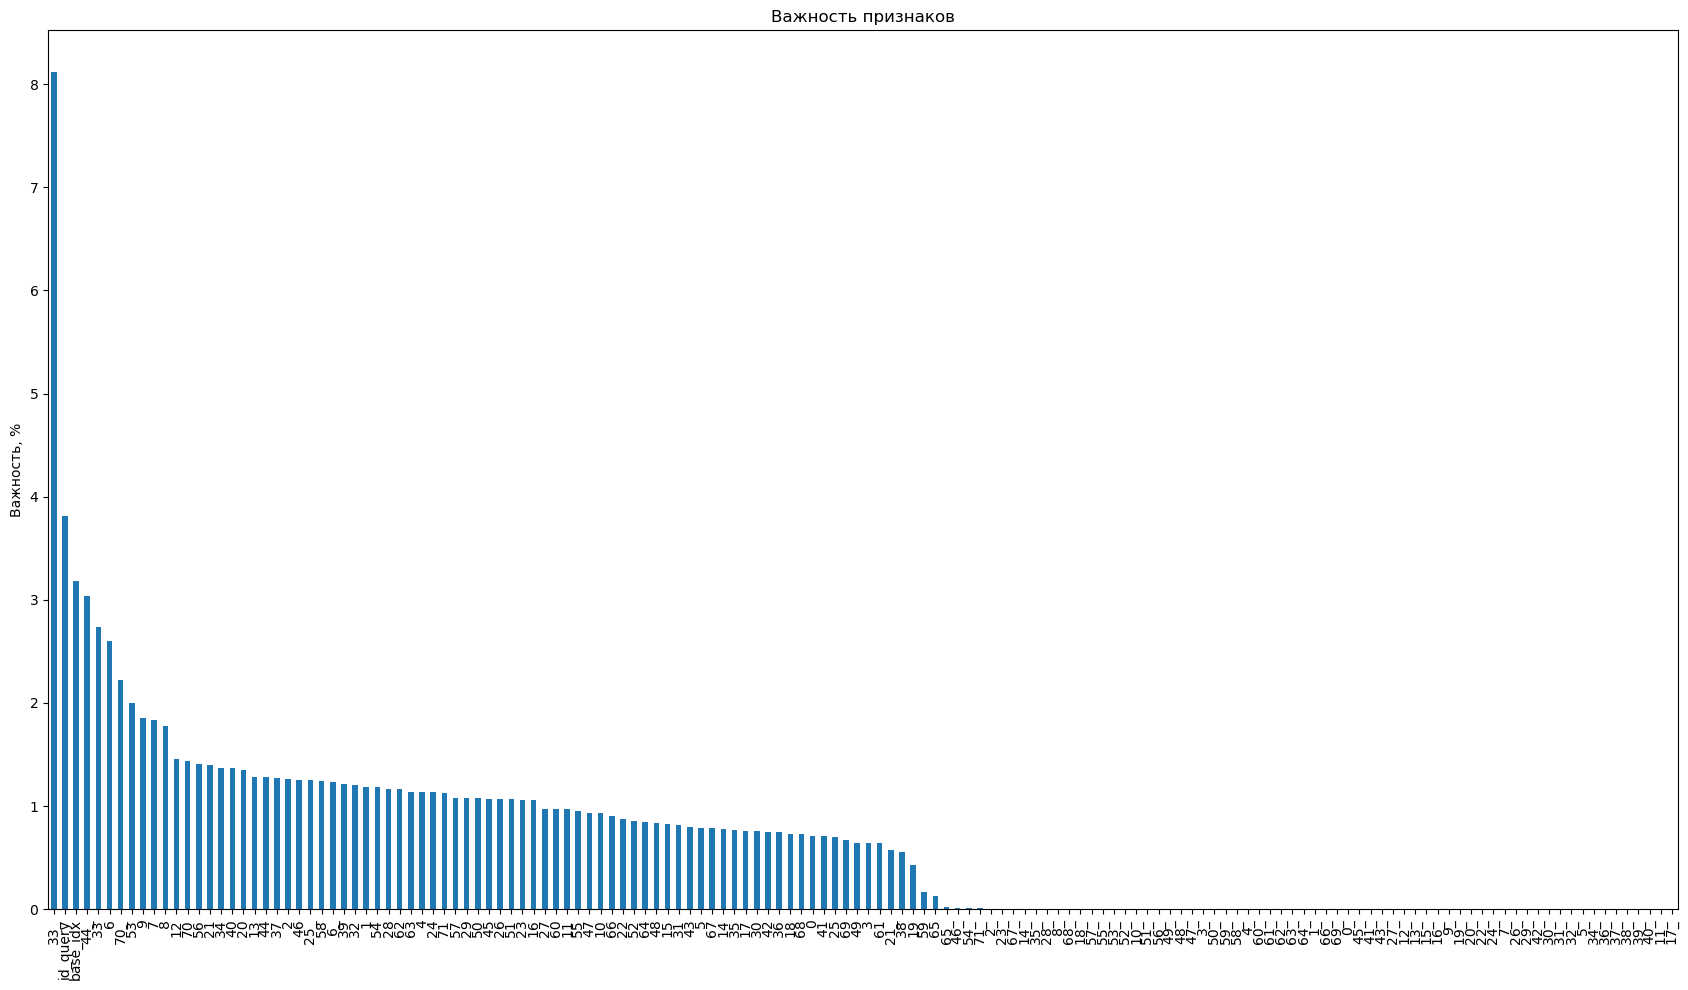

In [71]:
features_importance = pd.Series(model.get_feature_importance(),
                         (train_ml).columns).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(17, 10))
features_importance.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

In [72]:
prediction_pr = model.predict_proba(train_ml)
prediction_pr = prediction_pr[:,1]
prediction_pr

array([7.61539659e-02, 1.39920911e-01, 2.22138764e-02, ...,
       1.21012399e-03, 7.37295378e-05, 2.63821617e-04])

In [73]:
df_ml['prediction_pr'] = prediction_pr
df_ml.head(30)

,id_query,base_idx,target_idx,target,prediction_pr
0,0-query,361564-base,675816-base,0,0.076153966
1,0-query,1375561-base,675816-base,0,0.139920911
2,0-query,2515747-base,675816-base,0,0.022213876
3,0-query,244376-base,675816-base,0,0.058733708
4,0-query,530165-base,675816-base,0,0.091093197
5,0-query,3543241-base,675816-base,0,0.024233693
6,0-query,3411737-base,675816-base,0,0.006190980
7,0-query,877519-base,675816-base,0,0.000100353
8,0-query,499041-base,675816-base,0,0.043445433
9,0-query,91611-base,675816-base,0,0.058222697


In [74]:
df_ml_group = df_ml.sort_values(['id_query','prediction_pr'],ascending=False).groupby('id_query').head()
df_ml_group.head(30)

,id_query,base_idx,target_idx,target,prediction_pr
4999950,99999-query,2769109-base,2769109-base,1,0.999844565
4999974,99999-query,1474295-base,2769109-base,0,0.063336012
4999978,99999-query,2828616-base,2769109-base,0,0.038626195
4999994,99999-query,1545221-base,2769109-base,0,0.009598314
4999951,99999-query,771164-base,2769109-base,0,0.007594361
4999940,99998-query,3115447-base,9252-base,0,0.283178646
4999934,99998-query,2783591-base,9252-base,0,0.002864287
4999935,99998-query,4619072-base,9252-base,0,0.002864287
4999909,99998-query,315187-base,9252-base,0,0.002136385
4999912,99998-query,1695869-base,9252-base,0,0.001931525


In [75]:
summa = df_ml_group['target'].sum()
summa

77028

In [76]:
ass_5_ml = 100*summa/(len(df_ml_group)/5)
ass_5_ml 

77.028

## Протестируем на тестовой выборке df_validation.

In [77]:
prediction_pr_v = model.predict_proba(test_ml)
prediction_pr_v = prediction_pr_v[:,1]
prediction_pr_v

array([9.75430945e-02, 1.10752902e-01, 7.24611222e-02, ...,
       4.41214390e-04, 1.41280799e-07, 1.29219136e-03])

In [78]:
df_ml_v['prediction_pr'] = prediction_pr_v
df_ml_v.head()

,id_query,base_idx,target_idx,target,prediction_pr
0,100000-query,2760762-base,2676668-base,0,0.097543094
1,100000-query,3209652-base,2676668-base,0,0.110752902
2,100000-query,1542803-base,2676668-base,0,0.072461122
3,100000-query,3839597-base,2676668-base,0,0.086804684
4,100000-query,508555-base,2676668-base,0,0.017886312


In [79]:
df_ml_group_v = df_ml_v.sort_values(['id_query','prediction_pr'],ascending=False).groupby('id_query').head()
df_ml_group_v.head(10)

,id_query,base_idx,target_idx,target,prediction_pr
4999994,199999-query,1822630-base,336472-base,0,0.015313449
4999955,199999-query,354733-base,336472-base,0,0.003178679
4999953,199999-query,4678196-base,336472-base,0,0.002882274
4999954,199999-query,2818124-base,336472-base,0,0.001303601
4999987,199999-query,2385617-base,336472-base,0,0.001293379
4999900,199998-query,341779-base,341779-base,1,0.999412756
4999914,199998-query,4597186-base,341779-base,0,0.004770365
4999921,199998-query,2601333-base,341779-base,0,0.002204263
4999927,199998-query,1435048-base,341779-base,0,0.002019737
4999923,199998-query,4734162-base,341779-base,0,0.000331083


In [80]:
summ = df_ml_group_v['target'].sum()
summ

73748

In [82]:
ass_5_ml_v = 100*summ/(len(df_ml_group)/5)
ass_5_ml_v 

73.748

**Вывод**: С использование Faiss получилось достьичь точности accuracy@5 70.017. Для улучшения результатов поиска решила разработать модель классификации, выгрузив из Faiss 50 ближайших соседей. Решила использовать CatBoostClassifier. Для обучения создала датасет с индексами векторов запроса и предлагаемых векторов, в качестве других признаков использовались растояние между признаками, равенство признаков (бинарные признаки). Я пробовала разные комбинации признаков, но у меня не получилось улучшить результат, максимальный - уровень качества после Faiss accuracy@5 70.017 при сочетании индексов векторов и бинарных признаков. Отдельно смотрела распределения признаков, в данной тетрадке их нет. Распределения всех признаков выглядят приблизительно одинаково, кроме '6', '21', '25', '33', '44', '59', '65', '70'. Эти признаки я удалила при использовании Faiss, но пыталась их использовать при обучении модели, но тоже не дало положительных результатов. Среди этих признаков хотя бы было понятно, где можно использовать растояние, а где бинарный признак. В итоге я решила сделать вариант обучения модели на всех признаках и в итоге получила accuracy@5 = 73.748, что лучше, чем после Faiss accuracy@5 70.017. Писала в процессе работы, уже не успеваю отсеить ненужные признаки, но постараюсь это сделать, т.к. планирую еще сделать докер файл.